In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-cost-prediction/medical_insurance.csv


In [2]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 6)
%matplotlib inline

# Medical Insurance Cost: ОБЗОР
# Модель предсказания цены на медицинскую страховку
---
- **Цель**: предсказать стоимость медицинской страховки на основе демографических и медицинских факторов.
- **Тип задачи**: регрессия.
- **Метрики**: RMSE, MAE, R².

# 1. Первичный осмотр данных.

In [3]:
df = pd.read_csv('/kaggle/input/medical-insurance-cost-prediction/medical_insurance.csv')
display(df.head())
display(df.info())
print(f'Размер: {df.shape[0]} записей на {df.shape[1]} признаков.')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


None

Размер: 2772 записей на 7 признаков.


In [4]:
print(f'ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:')
display(df.describe())

ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:


,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
# Проверка на пустые ячейки
def fill_empty_data(df):
    # TODO: Функция для заполнения пустых ячеек.
    ...
    return df
    

if df.isna().any().any():
    print(f'Пустые записи:\n{df.info()}')
    df = fill_empty_data(df=df)
    print('Пустые ячейки заполнены.')
else:
    print('Нет пустых записей.')

print('_' * 45)

# Проверка на дупликаты
duplicated = df.duplicated().sum()

if duplicated:
    initial_len = df.shape[0]
    print(f'Найдено {duplicated} повторяющихся записей.')
    df = df.drop_duplicates().reset_index(drop=True)
    print(f'Дубликаты удалены; новый размер датасета: {initial_len} -> {df.shape[0]} строк.')
else:
    print('Нет повторяющихся запией.')

Нет пустых записей.
_____________________________________________
Найдено 1435 повторяющихся записей.
Дубликаты удалены; новый размер датасета: 2772 -> 1337 строк.


# 2. Разведочный анализ данных (EDA)

In [6]:
num_features = {
    'age': 'Возраст',
    'bmi': 'Индекс BMI',
    'children': 'Количество детей',
    'charges': 'Цена мед. страховки'
}

cat_features = {
    'sex': 'Пол',
    'smoker': 'Привычка курения',
    'region': 'Регион'
}

In [7]:
from scipy import *
from scipy.stats import *

# Доверительный интервал
def confidence_interval(feature, alpha=.95):
    n = len(df[feature])
    mean = df[feature].mean()
    std = df[feature].std()
    se = std/np.sqrt(n)
    interval = norm.interval(confidence=alpha, loc=mean, scale=se)

    return interval

In [8]:
confidence_interval('age')[0]

38.46933237961973

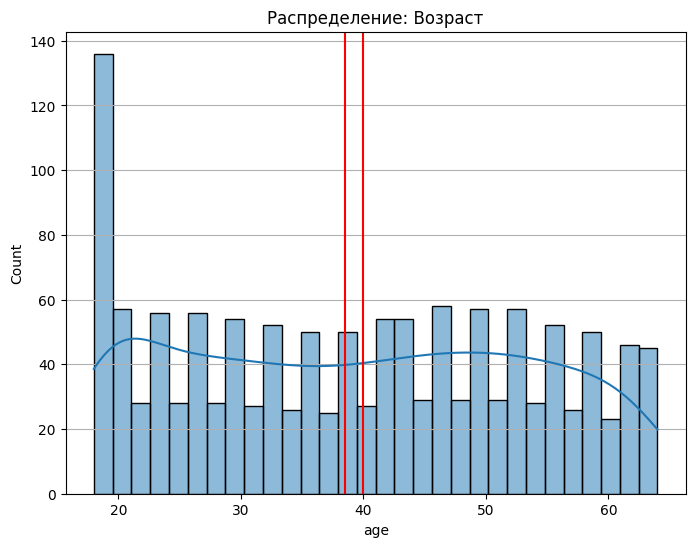

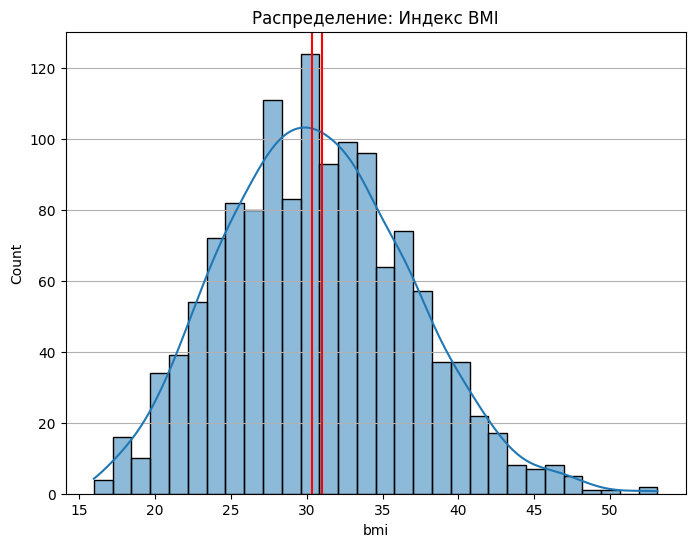

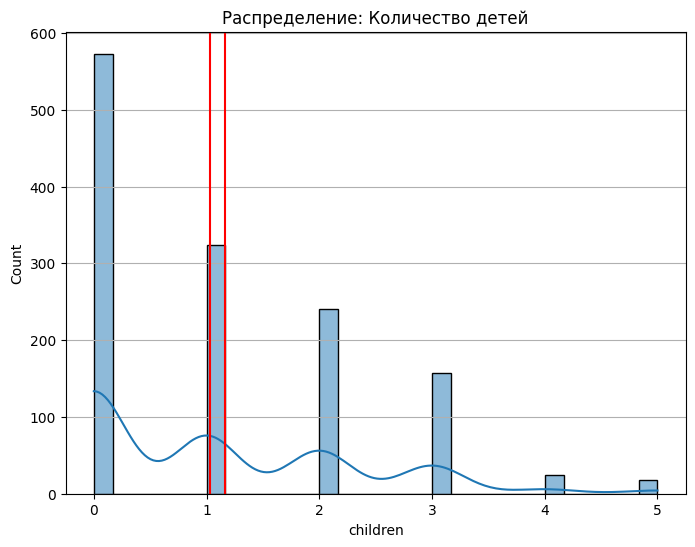

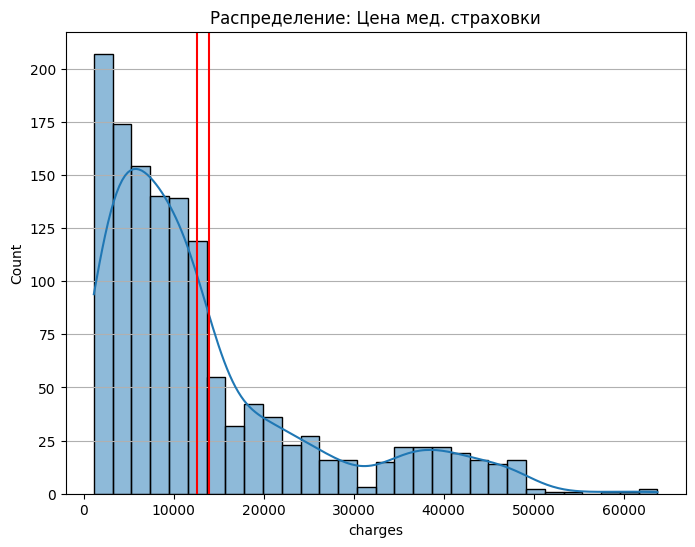

In [9]:
for feature, feature_name in num_features.items():
    sns.histplot(data=df, x=feature, kde=True, bins=30)
    plt.title(f'Распределение: {feature_name}')
    # Границы доверительного интервала
    plt.axvline(x=confidence_interval(feature)[0], color='red')
    plt.axvline(x=confidence_interval(feature)[1], color='red')
    plt.grid(axis='y')
    plt.show()

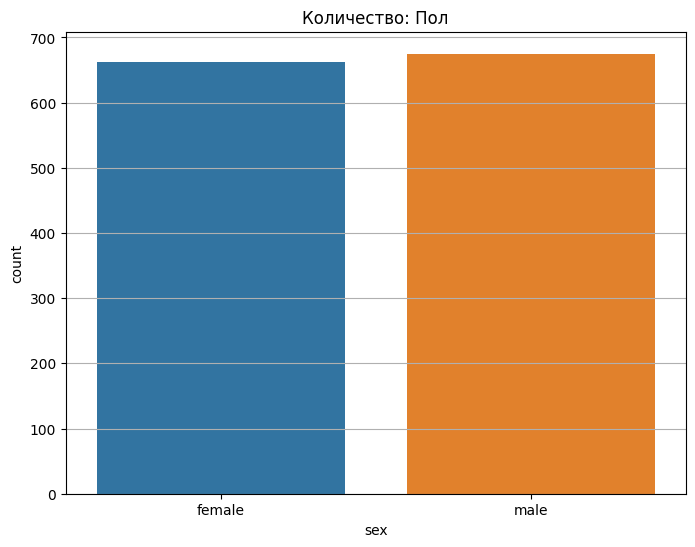

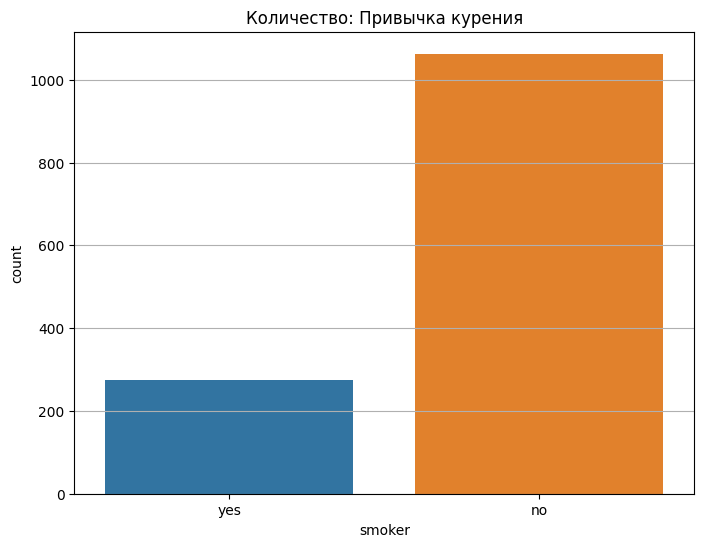

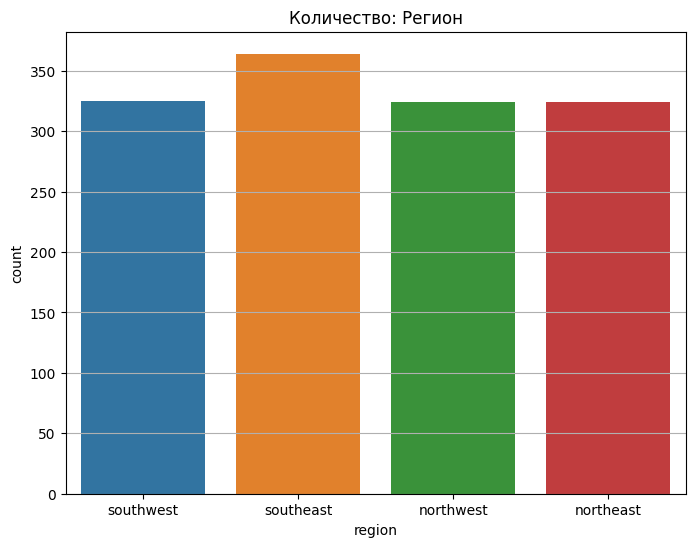

In [10]:
for feature, feature_name in cat_features.items():
    sns.countplot(x=df[feature])
    plt.title(f'Количество: {feature_name}')
    plt.grid(axis='y')
    plt.show()

In [11]:
genders = pd.DataFrame(df['sex'].value_counts())
genders['percentage'] = (genders['count'] / len(df) * 100).round(2)
genders

,count,percentage
sex,,
male,675,50.49
female,662,49.51


## Числовые признаки
### Возраст
- Распределение относительно равномерное во всех возрастах от 20 до 60 лет.
- Выраженный пик на значении 18 лет (возможно, особенность датасета).

### Индекс BMI
- Распределение близко к нормальному с центром около 30 единиц (граница избыточного веса).
- Наблюдается лёгкая асимметрия вправо (правый хвост - значения выше 40–45).

### Количество детей
- Большинство респондентов не имеют детей.
- Среднее кол-во детей у респондентов - 1. Редко встречаются известные данные о 4 и более детях.

### Цена медицинской страховки **(целевой признак)**
-Большинство клиентов платят до 15 000 у.е., но есть выбросы свыше 60 000.
- Вероятно, выбросы связаны с возрастом.

## Категориальные признаки
### Пол
- Распределение мужчин и женщин почти идеально сбалансировано (мужчин - 675, женщин - 662, 50.5% и 49.5% соответственно).

### Привычка курения
- Большинство клиентов — некурящие (~80%).
- Курильщиков заметно меньше, но **они могут оказывать сильное влияние на стоимость страховки**.

In [12]:
df['sex'] = df['sex'].map({
    'male': 0,
    'female': 1
})
df['smoker'] = df['smoker'].map({
    'yes': 1,
    'no': 0
})

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


In [13]:
cat_features.items()

dict_items([('sex', 'Пол'), ('smoker', 'Привычка курения'), ('region', 'Регион')])

In [14]:
# Проверка значимости бинарных признаков (курение, пол)
for feature, name_features in list(cat_features.items())[:-1]: # Кроме последнего НЕбинарного признака - регион
    sample_true = df[df[feature] == 1]['charges']
    sample_false = df[df[feature] == 0]['charges']
    
    mean_true = sample_true.mean()
    mean_false = sample_false.mean()
    
    t, p = ttest_ind(sample_true, sample_false, equal_var=False)
    print(f'{name_features}: потенциально {"ВЛИЯЕТ" if p <.05 else "НЕ ВЛИЯЕТ"} на цену мед. страховки; p-value={p:.4f}')

Пол: потенциально ВЛИЯЕТ на цену мед. страховки; p-value=0.0336
Привычка курения: потенциально ВЛИЯЕТ на цену мед. страховки; p-value=0.0000


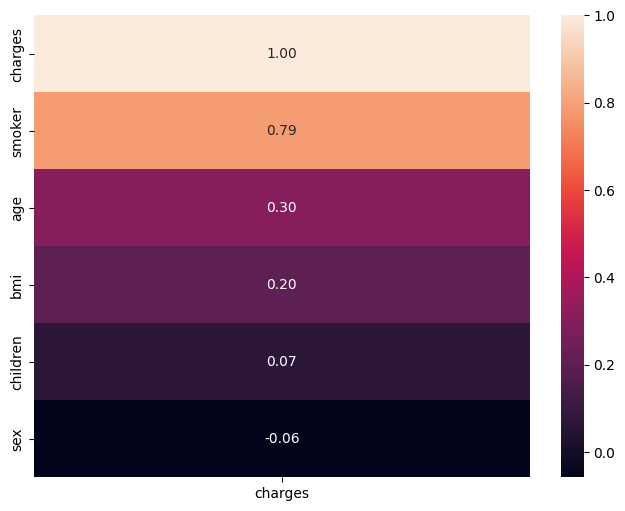

,charges
charges,1.000000
smoker,0.787234
age,0.298308
bmi,0.198401
children,0.067389
sex,-0.058044


In [15]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr[['charges']].sort_values(by='charges', ascending=False), annot=True, fmt='.2f')
plt.show()
display(pd.DataFrame(df_corr['charges'].sort_values(ascending=False)))